# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [38]:
# Load pickled data
import pickle
from skimage import color

traffic_data_directory = "/home/carson/Documents/traffic_data/"
training_file = traffic_data_directory + "train.p"
validation_file= traffic_data_directory + "valid.p"
testing_file = traffic_data_directory + "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("Loaded data")

num_image_channels = 3

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

# Carson's custom test files
import matplotlib.image as mpimg
test_files = ['examples/seventy.jpg',
              'examples/pedestrians.jpg',
              'examples/beware_of_ice_snow.jpg',
              'examples/priority_road.jpg',
              'examples/no_passing.jpg']

X_test2 = np.array([mpimg.imread(filename) for filename in test_files])
y_test2 = np.array([4, 27, 30, 12, 9])

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Number of custom examples =", X_test2.shape[0])
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# def normalize(x):
#     X = np.copy(x)
#     X = X.astype(np.float64)
#     mean_image = np.mean(X_train.astype(np.float64), axis=0, dtype=np.float64)
#     X -= mean_image
#     X /= np.std(X_train.astype(np.float64))
#     return X

# X_train_normalized = normalize(X_train)
# X_valid_normalized = normalize(X_valid)
# X_test_normalized = normalize(X_test)

X_train = X_train.astype(np.float64)
np.std(X_train)
mean_image = np.mean(X_train, axis=0, dtype=np.float64)
X_train_stddev = np.std(X_train)
X_train -= mean_image
X_train /= X_train_stddev

X_valid = X_valid.astype(np.float64)
X_valid -= mean_image
X_valid /= X_train_stddev

X_test = X_test.astype(np.float64)
X_test -= mean_image
X_test /= X_train_stddev
print("Normalized train, validation, and test datasets.")

Loaded data
Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Number of custom examples = 5
Image data shape = (32, 32, 3)
Number of classes = 43
Normalized train, validation, and test datasets.


In [45]:
from keras import utils
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import optimizers
from keras import callbacks
from sklearn.utils import shuffle

droprate = 0.5
conv1_nfilters = 12
conv2_nfilters = 32
fc1_nodes = 120
fc2_nodes = 84
activation = 'elu'

model = Sequential()
model.add(Conv2D(filters=conv1_nfilters, kernel_size=(5, 5), input_shape=(32, 32, 3)))
model.add(Activation(activation))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(droprate))
model.add(Conv2D(filters=conv2_nfilters, kernel_size=(5, 5)))
model.add(Activation(activation))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(droprate))
model.add(Flatten())
model.add(Dense(fc1_nodes))
model.add(Activation(activation))
model.add(Dropout(droprate))
model.add(Dense(fc2_nodes))
model.add(Activation(activation))
model.add(Dropout(droprate))
model.add(Dense(n_classes, activation='softmax'))

epoch_end = {}
epoch_end['train_loss'] = []
epoch_end['train_acc'] = []

class TrainCallback(callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        epoch_end['train_loss'].append(loss)
        epoch_end['train_acc'].append(acc)
        print('\nEpoch end loss: {}, acc: {}\n'.format(loss, acc))
        
y_one_hot = utils.to_categorical(y_train, n_classes)
y_valid_one_hot = utils.to_categorical(y_valid, n_classes)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_one_hot, batch_size=128, epochs=20, validation_data=(X_valid, y_valid_one_hot))
#                    callbacks=[TrainCallback((X_train, y_one_hot))])
        
score = model.evaluate(X_train, y_one_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 34799 samples, validate on 4410 samples
Epoch 1/20
34799/34799 [==============================] - 1s - loss: 2.4405 - acc: 0.3482 - val_loss: 1.0969 - val_acc: 0.6907
Epoch 2/20
34799/34799 [==============================] - 1s - loss: 1.2297 - acc: 0.6251 - val_loss: 0.5968 - val_acc: 0.8315
Epoch 3/20
34799/34799 [==============================] - 1s - loss: 0.9179 - acc: 0.7180 - val_loss: 0.4800 - val_acc: 0.8526
Epoch 4/20
34799/34799 [==============================] - 1s - loss: 0.7592 - acc: 0.7678 - val_loss: 0.3731 - val_acc: 0.8991
Epoch 5/20
34799/34799 [==============================] - 1s - loss: 0.6633 - acc: 0.7943 - val_loss: 0.3172 - val_acc: 0.9147
Epoch 6/20
34799/34799 [==============================] - 1s - loss: 0.6200 - acc: 0.8102 - val_loss: 0.2788 - val_acc: 0.9268
Epoch 7/20
34799/34799 [==============================] - 1s - loss: 0.5659 - acc: 0.8268 - val_loss: 0.2916 - val_acc: 0.9240
Epoch 8/20
34799/34799 [==============================] - 1s -

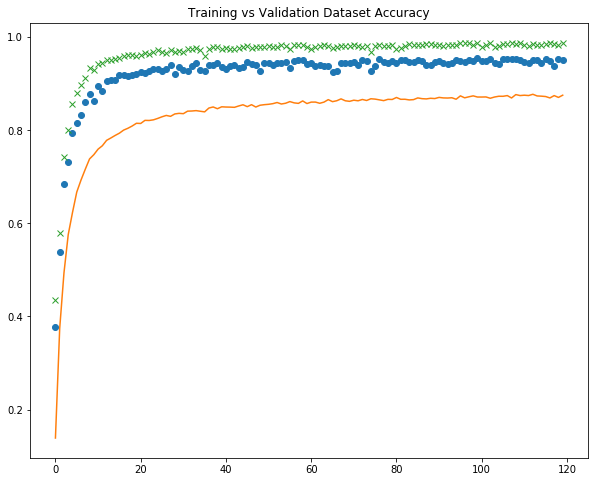

In [33]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# Why is training accuracy lower than validation accuracy?
# Training accuracy is the average of accuracies of all batches during an epoch.
# Validation accuracy is the accuracy of the entire dataset.
# See https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss
plt.plot(history.history['val_acc'], 'o', label='baseline') 
plt.plot(history.history['acc'], '-', label='baseline') # This is the avg training acc for each batch
plt.plot(epoch_end['train_acc'], 'x', label='baseline') # This is the training acc at the end of an epoch.
plt.title("Training vs Validation Dataset Accuracy")

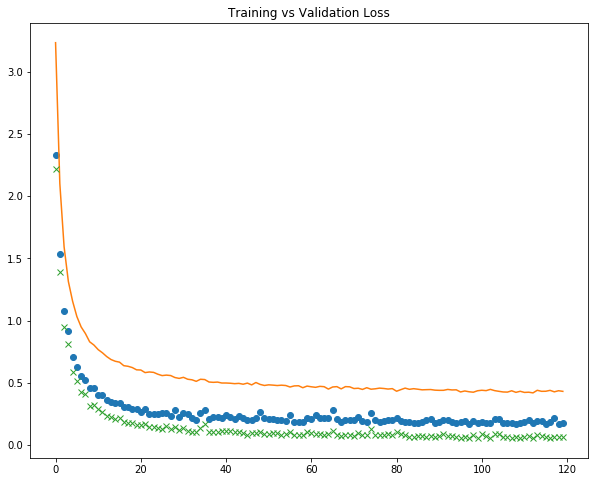

In [34]:
plt.plot(history.history['val_loss'], 'o', label='baseline')
plt.plot(history.history['loss'], '-', label='baseline')
plt.plot(epoch_end['train_loss'], 'x', label='baseline')
plt.title("Training vs Validation Loss")

In [24]:
from keras.models import load_model
model.save('model.h5')
model = load_model('model.h5')

X_test2 = np.array([mpimg.imread(filename) for filename in test_files])
y_test2 = np.array([4, 27, 30, 12, 9])

y_test_one_hot = utils.to_categorical(y_test, n_classes)
y_test2_one_hot = utils.to_categorical(y_test2, n_classes)

score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

score = model.evaluate(X_test2, y_test2_one_hot, verbose=0)
print('Custom set loss:', score[0])
print('Custome set accuracy:', score[1])

Test loss: 0.24063556825
Test accuracy: 0.932066508408
Custom set loss: 3.22361922264
Custome set accuracy: 0.800000011921


---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")